# SDSS Galaxies vs Quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey.

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g.

- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) arXiv:1909.10963
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) arXiv:1910.05255

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported here

**Tasks**

- Create arrays for the $(u - g)$, $(g - r)$, $(r - i)$, and $(i - z)$ colors. Also create an array with the class labels where galaxy = 0 and quasar = 1.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

**Ideas**

- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from astroML.classification import GMMBayes

## Dataset

In [3]:
data = pd.read_csv('galaxyquasar.csv')
print(data)

              u         g         r         i         z   class        z1  \
0      18.97213  18.53676  18.58280  18.34936  18.29215     QSO  0.522819   
1      19.24592  17.47646  16.47817  16.04472  15.68851  GALAXY  0.122846   
2      19.43536  17.70268  16.91565  16.58327  16.39128  GALAXY  0.000000   
3      19.31626  18.18312  17.39591  16.94549  16.65395  GALAXY  0.147435   
4      19.28828  19.11188  18.88937  18.80013  18.49183     QSO  2.011455   
...         ...       ...       ...       ...       ...     ...       ...   
49995  19.37295  18.12382  17.39886  16.98503  16.70585  GALAXY  0.113016   
49996  18.52021  16.88262  16.03280  15.56884  15.22454  GALAXY  0.085063   
49997  18.62718  17.30876  16.87371  16.62399  16.42296  GALAXY  0.054429   
49998  19.55140  18.27711  17.62101  17.21947  17.03347  GALAXY  0.112571   
49999  18.80772  17.75751  17.40500  17.21650  17.12295  GALAXY  0.043652   

           zerr  
0      0.000155  
1      0.000028  
2      0.000000  
3  

In [4]:
# Colors array
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])

X = np.column_stack((u_g, g_r, r_i, i_z))

# Galaxy or quasar
le = LabelEncoder()
labels = le.fit_transform(data['class']) # galaxy = 0 and quasar = 1

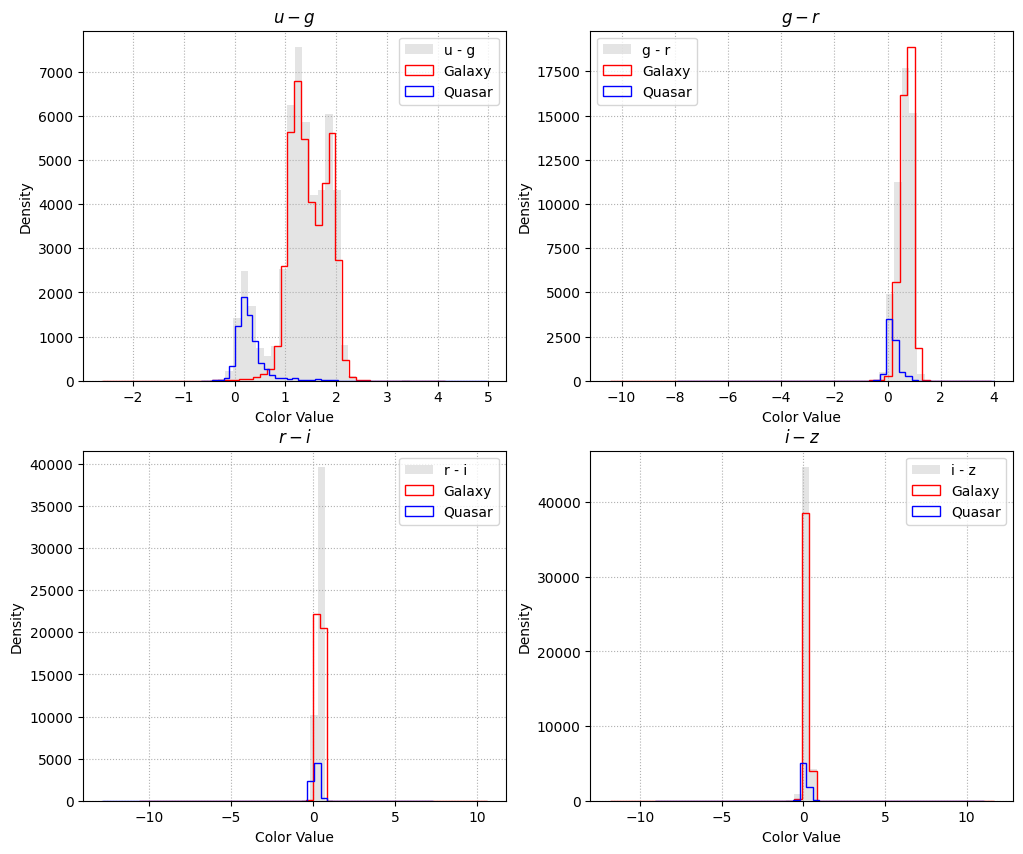

In [80]:
colors = {'u - g': u_g, 'g - r': g_r, 'r - i': r_i, 'i - z': i_z}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, color_array) in enumerate(colors.items()):
    ax = axes[idx]

    # Mask for each class
    galaxy_mask = labels == 0
    quasar_mask = labels == 1

    ax.hist(color_array, bins= 50, color='lightgray', label = name, alpha = 0.6)
    ax.hist(color_array[galaxy_mask],bins= 50, color='red', histtype = 'step',label='Galaxy')
    ax.hist(color_array[quasar_mask], bins= 50, color='blue', histtype = 'step', label='Quasar')

    ax.set_title(f'${name}$')
    ax.set_xlabel('Color Value')
    ax.set_ylabel('Density')
    ax.grid(linestyle = ':')
    ax.legend()

plt.show()

As the $(u - g)$ projection is the only one which seems to exhibite bimodality, the analysis is first focused on this feature before being extended to the entire dataset.

In [42]:
# Split train and test datasets
# u - g
ug_train, ug_test, y_train, y_test = train_test_split(u_g, labels, test_size=0.3, random_state=1)

# entire dataset
X_train, X_test, y_train_AD, y_test_AD =  train_test_split(X, labels, test_size=0.33, random_state=1)

## GMM Bayes Classifier

### $(u - g)$ Data

Max accurancy score is for n = 4


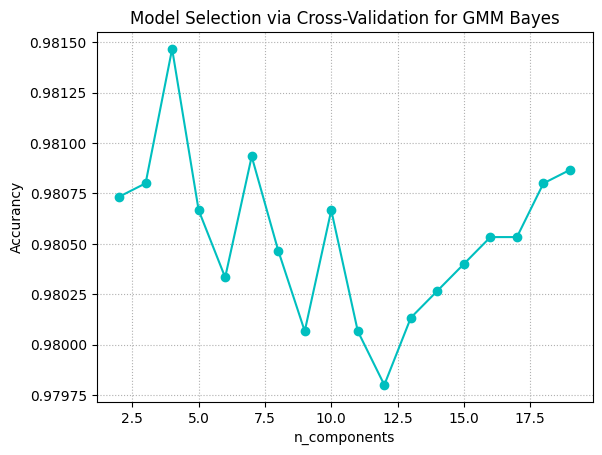

In [43]:
# Cross-Validation
acc_scores = []
n_gauss = np.arange(2,20)

for n in n_gauss:
    clf = GMMBayes(n, covariance_type='full', random_state=42)
    CVpredk = cross_val_predict(clf, ug_test[:, None], y_test)
    acc_scores.append(accuracy_score(y_test, CVpredk))

max_n = n_gauss[np.argmax(acc_scores)]
print(f'Max accurancy score is for n = {max_n}')

# Plot
plt.plot(n_gauss, acc_scores, marker='o', color='c')
plt.xlabel('n_components')
plt.ylabel('Accurancy')
plt.title('Model Selection via Cross-Validation for GMM Bayes')
plt.grid(linestyle = ':')
plt.show()

ROC AUC: 0.9863


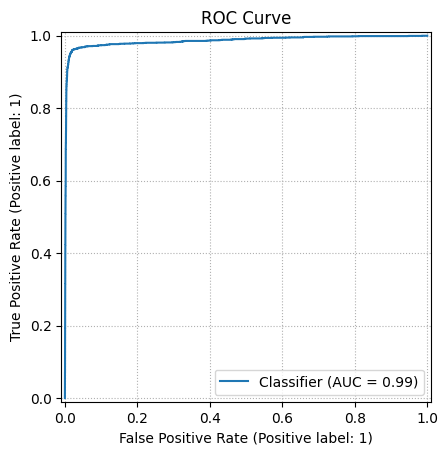

In [44]:
# Classification with GMM Bayes classifier
GMMB = GMMBayes(n_components=max_n, covariance_type='full')
GMMB.fit(ug_train[:, None], y_train)

y_pred_GMMB_ug = GMMB.predict(ug_test[:, None])
y_proba = GMMB.predict_proba(ug_test[:, None])[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_GMMB_ug)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_GMMB_ug).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"GMMB accuracy: {accuracy_score(y_test, y_pred_GMMB_ug):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

GMMB accuracy: 0.9811
Completeness: 0.9279
Contamination: 0.0595


### All Data

Max accurancy score is for n = 16


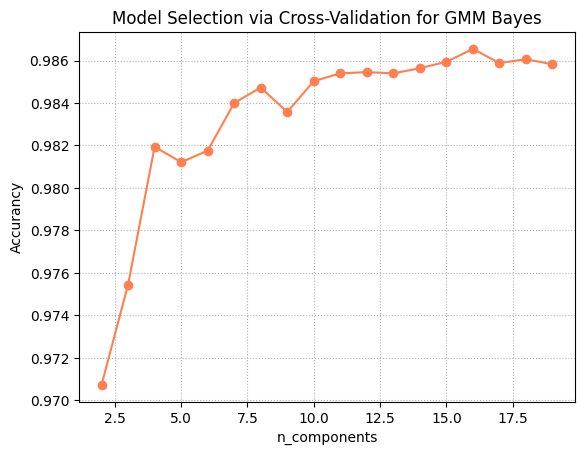

In [46]:
# Cross-Validation
acc_scores = []
n_gauss = np.arange(2,20)

for n in n_gauss:
    clf = GMMBayes(n, covariance_type='full', random_state=42)
    CVpredk = cross_val_predict(clf, X_test, y_test_AD)
    acc_scores.append(accuracy_score(y_test_AD, CVpredk))

max_n = n_gauss[np.argmax(acc_scores)]
print(f'Max accurancy score is for n = {max_n}')

# Plot
plt.plot(n_gauss, acc_scores, marker='o', color='coral')
plt.xlabel('n_components')
plt.ylabel('Accurancy')
plt.title('Model Selection via Cross-Validation for GMM Bayes')
plt.grid(linestyle = ':')
plt.show()

ROC AUC: 0.9950


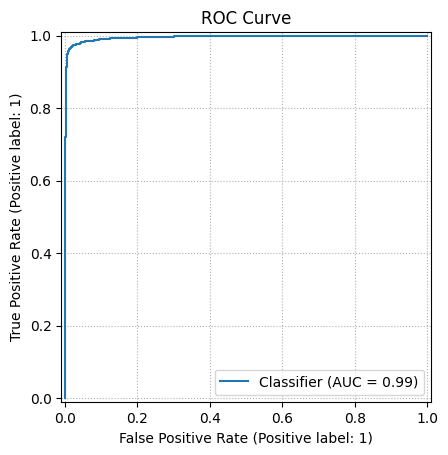

In [47]:
# Classification with GMM Bayes classifier for all data
GMMB = GMMBayes(n_components=max_n, covariance_type='full')
GMMB.fit(X_train, y_train_AD)

y_pred_GMMB_AD = GMMB.predict(X_test)
y_proba_AD = GMMB.predict_proba(X_test)[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test_AD, y_proba_AD):.4f}")

RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [48]:
# Confusion Matrix
cm = confusion_matrix(y_test_AD, y_pred_GMMB_AD)

tn, fp, fn, tp = confusion_matrix(y_test_AD, y_pred_GMMB_AD).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"GMMB accuracy: {accuracy_score(y_test_AD, y_pred_GMMB_AD):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

GMMB accuracy: 0.9860
Completeness: 0.9526
Contamination: 0.0494


### Comparison

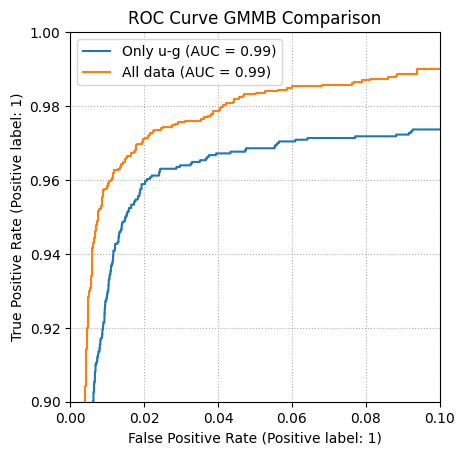

In [49]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_test, y_proba, name="Only u-g", ax=ax)
RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD, name="All data", ax=ax)

plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.title("ROC Curve GMMB Comparison")
plt.legend()
plt.grid(linestyle = ':')
plt.show()


## K-Neighbors Classifier

### $(u - g)$ Data

Max score is for k = 16


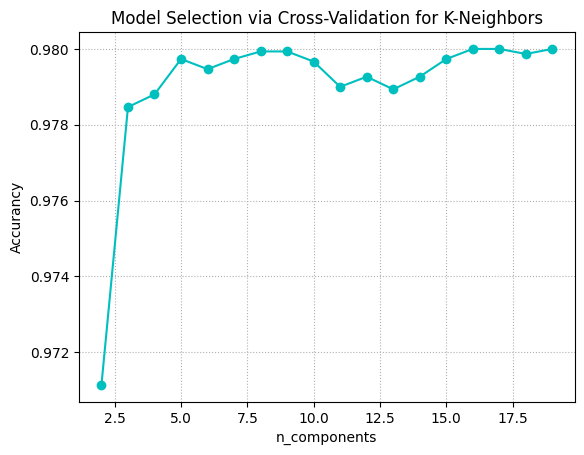

In [50]:
# Cross Validation
acc_scores = []
kvals = np.arange(2,20)

for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, ug_test[:, None], y_test)
    acc_scores.append(accuracy_score(y_test, CVpredk))

max_k = kvals[np.argmax(acc_scores)]
print(f'Max score is for k = {max_k}')

# Plot
plt.plot(kvals, acc_scores, marker='o', color='c')
plt.xlabel('n_components')
plt.ylabel('Accurancy')
plt.title('Model Selection via Cross-Validation for K-Neighbors')
plt.grid(linestyle = ':')
plt.show()

ROC AUC: 0.9796


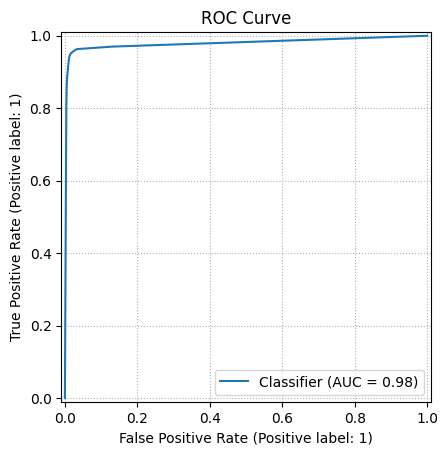

In [51]:
# Classification with GMM Bayes classifier for all data
KN = KNeighborsClassifier(n_neighbors=max_k)
KN.fit(ug_train[:, None], y_train)

y_pred_KN_ug = KN.predict(ug_test[:, None])
y_proba = KN.predict_proba(ug_test[:, None])[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [52]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_KN_ug)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_KN_ug).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"KN accuracy: {accuracy_score(y_test, y_pred_KN_ug):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

KN accuracy: 0.9811
Completeness: 0.9316
Contamination: 0.0632


### All Data

Max accurancy score is for k = 7


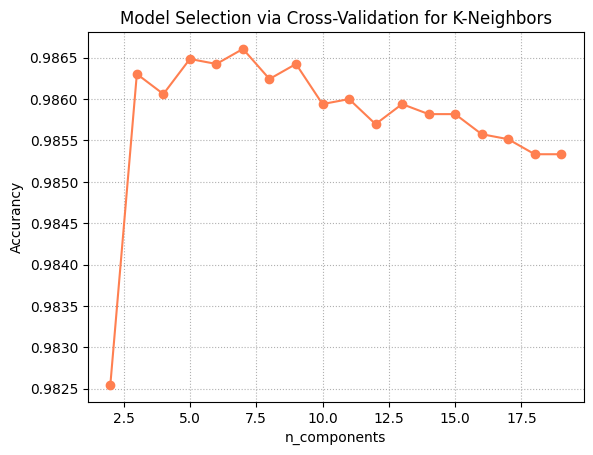

In [53]:
# Cross-Validation
acc_scores = []
kvals = np.arange(2,20)

for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X_test, y_test_AD)
    acc_scores.append(accuracy_score(y_test_AD, CVpredk))

max_k = kvals[np.argmax(acc_scores)]
print(f'Max accurancy score is for k = {max_k}')

# Plot
plt.plot(kvals, acc_scores, marker='o', color='coral')
plt.xlabel('n_components')
plt.ylabel('Accurancy')
plt.title('Model Selection via Cross-Validation for K-Neighbors')
plt.grid(linestyle = ':')
plt.show()

ROC AUC: 0.9876


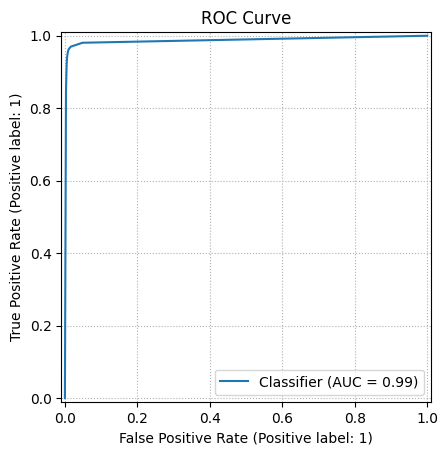

In [54]:
# Classification with GMM Bayes classifier for all data
KN = KNeighborsClassifier(n_neighbors=max_k)
KN.fit(X_train, y_train_AD)

y_pred_KN_AD = KN.predict(X_test)
y_proba_AD = KN.predict_proba(X_test)[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test_AD, y_proba_AD):.4f}")

RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [55]:
# Confusion Matrix
cm = confusion_matrix(y_test_AD, y_pred_KN_AD)

tn, fp, fn, tp = confusion_matrix(y_test_AD, y_pred_KN_AD).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"KN accuracy: {accuracy_score(y_test_AD, y_pred_KN_AD):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

KN accuracy: 0.9865
Completeness: 0.9505
Contamination: 0.0439


### Comparison

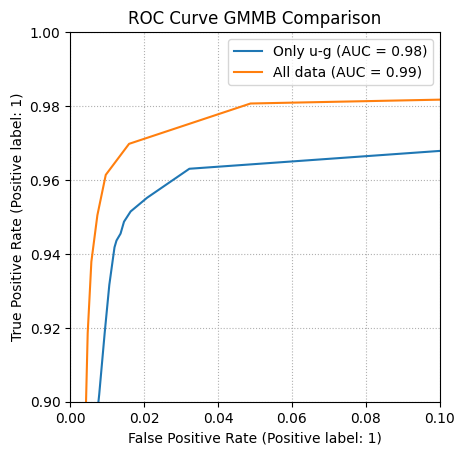

In [56]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_test, y_proba, name="Only u-g", ax=ax)
RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD, name="All data", ax=ax)

plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.title("ROC Curve GMMB Comparison")
plt.legend()
plt.grid(linestyle = ':')
plt.show()

## Quadratic Discriminant Analysis

### $(u - g)$ Data

ROC AUC: 0.9830


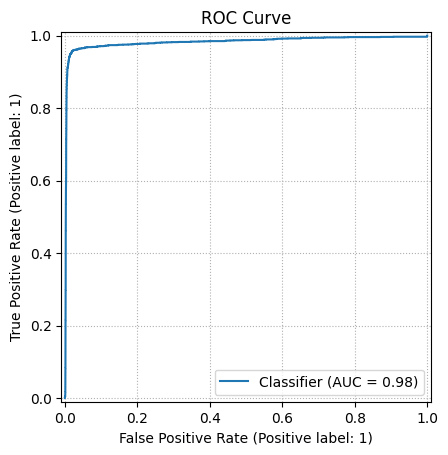

In [57]:
# Classification with GMM Bayes classifier for all data
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(ug_train[:, None], y_train)

y_pred_QDA_ug = QDA.predict(ug_test[:, None])
y_proba = QDA.predict_proba(ug_test[:, None])[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_QDA_ug)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_QDA_ug).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"QDA accuracy: {accuracy_score(y_test, y_pred_QDA_ug):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

QDA accuracy: 0.9811
Completeness: 0.9362
Contamination: 0.0668


### All Data

ROC AUC: 0.9838


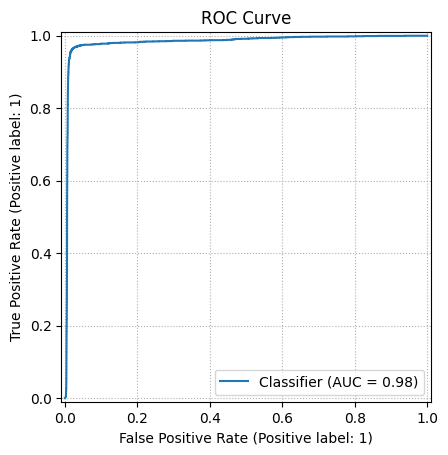

In [59]:
# Classification with GMM Bayes classifier for all data
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(X_train, y_train_AD)

y_pred_QDA_AD = QDA.predict(X_test)
y_proba_AD = QDA.predict_proba(X_test)[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test_AD, y_proba_AD):.4f}")

RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [60]:
# Confusion Matrix
cm = confusion_matrix(y_test_AD, y_pred_QDA_AD)

tn, fp, fn, tp = confusion_matrix(y_test_AD, y_pred_QDA_AD).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"QDA accuracy: {accuracy_score(y_test_AD, y_pred_QDA_AD):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

QDA accuracy: 0.9796
Completeness: 0.9232
Contamination: 0.0651


### Comparison

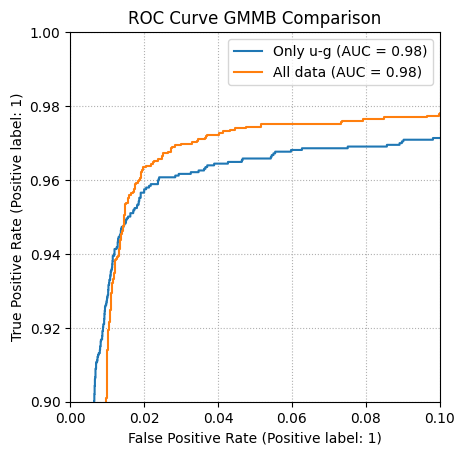

In [61]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_test, y_proba, name="Only u-g", ax=ax)
RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD, name="All data", ax=ax)

plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.title("ROC Curve GMMB Comparison")
plt.legend()
plt.grid(linestyle = ':')
plt.show()

## Gaussian Naive Bayes Classifier

### $(u - g)$ Data

ROC AUC: 0.9830


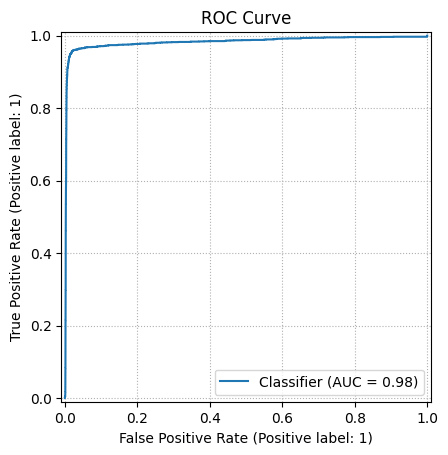

In [62]:
# Classification with GMM Bayes classifier for all data
GaussNB = GaussianNB()
GaussNB.fit(ug_train[:, None], y_train)

y_pred_GaussNB_ug = GaussNB.predict(ug_test[:, None])
y_proba = GaussNB.predict_proba(ug_test[:, None])[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [63]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_GaussNB_ug)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_GaussNB_ug).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"QDA accuracy: {accuracy_score(y_test, y_pred_GaussNB_ug):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

QDA accuracy: 0.9811
Completeness: 0.9362
Contamination: 0.0668


### All Data

ROC AUC: 0.9790


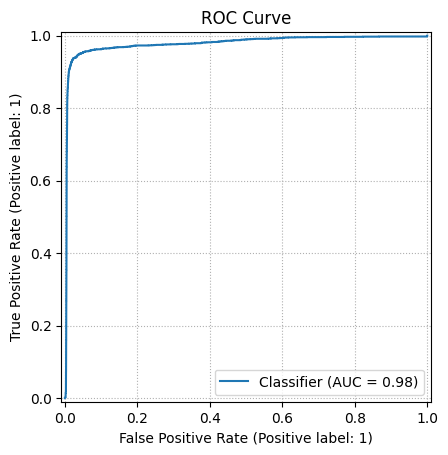

In [64]:
# Classification with GMM Bayes classifier for all data
GaussNB = GaussianNB()
GaussNB.fit(X_train, y_train_AD)

y_pred_GaussNB_AD = GaussNB.predict(X_test)
y_proba_AD = GaussNB.predict_proba(X_test)[:, 1]

# ROC Curve
print(f"ROC AUC: {roc_auc_score(y_test_AD, y_proba_AD):.4f}")

RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD)
plt.title("ROC Curve")
plt.grid(linestyle = ':')
plt.show()

In [65]:
# Confusion Matrix
cm = confusion_matrix(y_test_AD, y_pred_GaussNB_AD)

tn, fp, fn, tp = confusion_matrix(y_test_AD, y_pred_GaussNB_AD).ravel()
completeness_tree = tp / (tp + fn)
contamination_tree = fp / (tp + fp)

print(f"QDA accuracy: {accuracy_score(y_test_AD, y_pred_GaussNB_AD):.4f}")
print(f"Completeness: {completeness_tree:.4f}")
print(f"Contamination: {contamination_tree:.4f}")

QDA accuracy: 0.9734
Completeness: 0.9299
Contamination: 0.1094


### Comparison

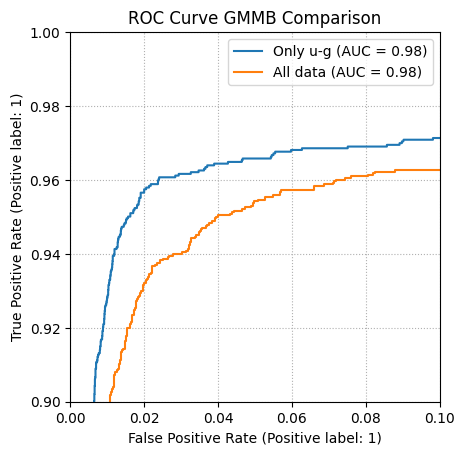

In [66]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_test, y_proba, name="Only u-g", ax=ax)
RocCurveDisplay.from_predictions(y_test_AD, y_proba_AD, name="All data", ax=ax)

plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.title("ROC Curve GMMB Comparison")
plt.legend()
plt.grid(linestyle = ':')
plt.show()

## Final Test

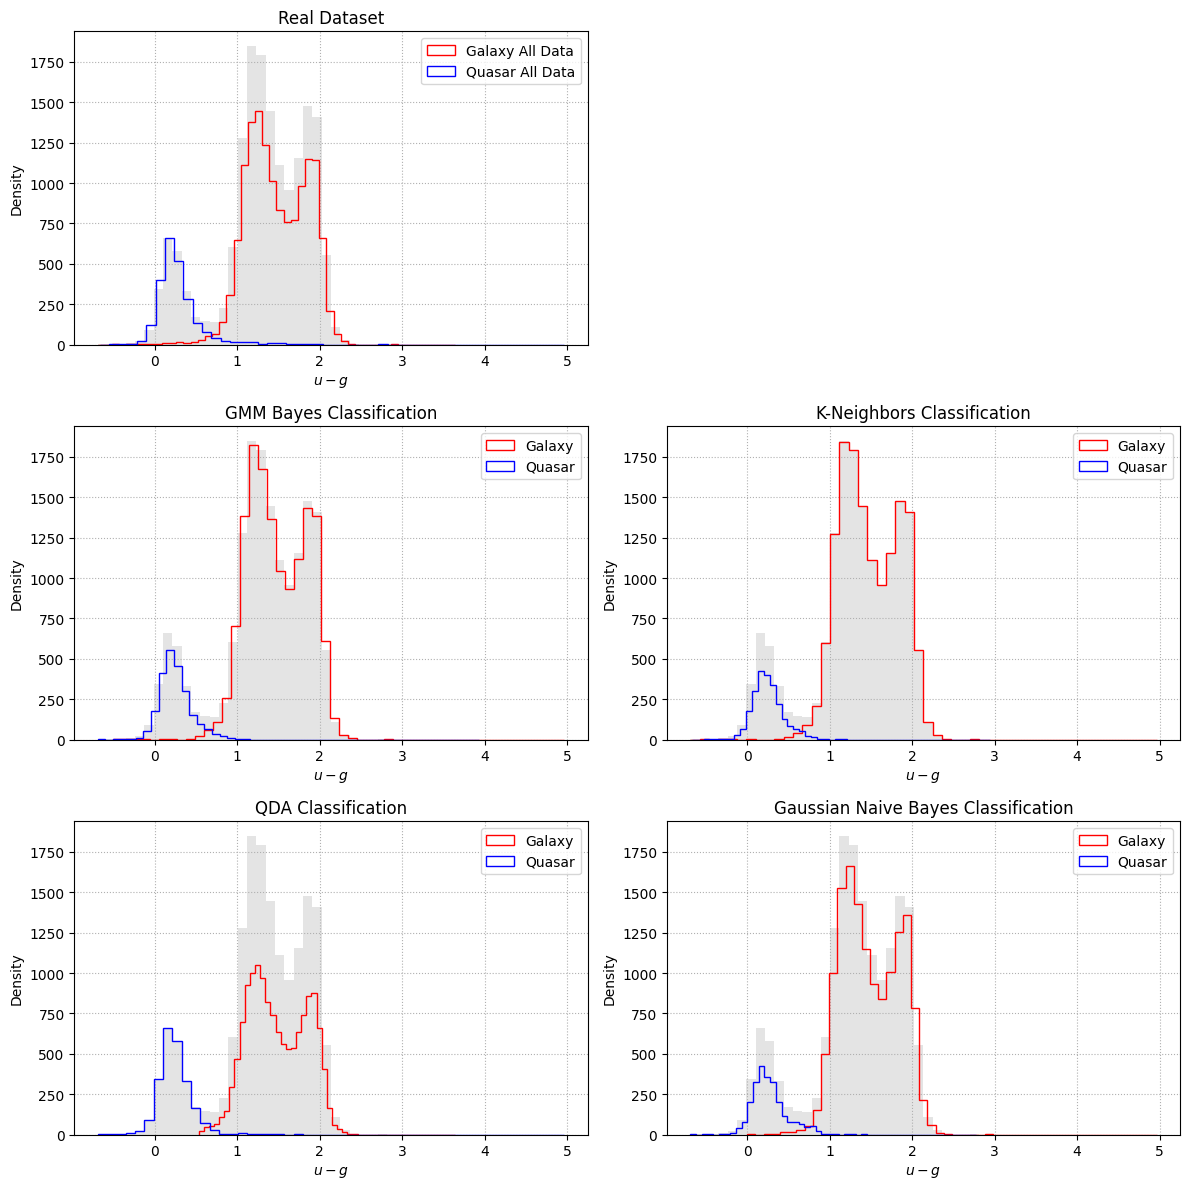

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.ravel()

# Real Dataset
axes[0].hist(X_test[:, 0], bins=50, color='lightgray', alpha=0.6)
axes[0].hist(X_test[:, 0][y_test_AD == 0], bins=50, color='red', histtype='step', label='Galaxy All Data')
axes[0].hist(X_test[:, 0][y_test_AD == 1], bins=50, color='blue', histtype='step', label='Quasar All Data')
axes[0].set_title('Real Dataset')
axes[0].set_xlabel('$u - g$')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(linestyle=':')

axes[1].axis('off')

# GMM Bayes Classification
axes[2].hist(X_test[:, 0], bins=50, color='lightgray', alpha=0.6)
axes[2].hist(X_test[:, 0][y_pred_GMMB_AD == 0], bins=50, color='red', histtype='step', label='Galaxy')
axes[2].hist(X_test[:, 0][y_pred_GMMB_AD == 1], bins=50, color='blue', histtype='step', label='Quasar')
axes[2].set_title('GMM Bayes Classification')
axes[2].set_xlabel('$u - g$')
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(linestyle=':')

# K-Neighbors Classification
axes[3].hist(X_test[:, 0], bins=50, color='lightgray', alpha=0.6)
axes[3].hist(X_test[:, 0][y_pred_KN_AD == 0], bins=50, color='red', histtype='step', label='Galaxy')
axes[3].hist(X_test[:, 0][y_pred_KN_AD == 1], bins=50, color='blue', histtype='step', label='Quasar')
axes[3].set_title('K-Neighbors Classification')
axes[3].set_xlabel('$u - g$')
axes[3].set_ylabel('Density')
axes[3].legend()
axes[3].grid(linestyle=':')

# QDA Classification
axes[4].hist(X_test[:, 0], bins=50, color='lightgray', alpha=0.6)
axes[4].hist(X_test[:, 0][y_pred_QDA_AD == 0], bins=50, color='red', histtype='step', label='Galaxy')
axes[4].hist(X_test[:, 0][y_pred_QDA_AD == 1], bins=50, color='blue', histtype='step', label='Quasar')
axes[4].set_title('QDA Classification')
axes[4].set_xlabel('$u - g$')
axes[4].set_ylabel('Density')
axes[4].legend()
axes[4].grid(linestyle=':')

# Gaussian Naive Bayes Classification
axes[5].hist(X_test[:, 0], bins=50, color='lightgray', alpha=0.6)
axes[5].hist(X_test[:, 0][y_pred_GaussNB_AD == 0], bins=50, color='red', histtype='step', label='Galaxy')
axes[5].hist(X_test[:, 0][y_pred_GaussNB_AD == 1], bins=50, color='blue', histtype='step', label='Quasar')
axes[5].set_title('Gaussian Naive Bayes Classification')
axes[5].set_xlabel('$u - g$')
axes[5].set_ylabel('Density')
axes[5].legend()
axes[5].grid(linestyle=':')

fig.tight_layout()
plt.show()